In [2]:
import os
import sys
import re
import numpy as np
import matplotlib.pyplot as plt

from ReadMaestro import maestro
from ReadMaestro import parse_pursuit_trials
paths = [p for p in sys.path if os.path.exists(p)]
print(paths)

from importlib import reload
reload(maestro)
reload(parse_pursuit_trials)

['/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '/home/seth/.local/lib/python3.9/site-packages', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages']


<module 'ReadMaestro.parse_pursuit_trials' from '/home/seth/analysis/ReadMaestro/ReadMaestro/parse_pursuit_trials.py'>

In [3]:
#file_path = '/home/seth/Projects/DynamicCoherencePhysiology/ar/20220404a/ar220404a.0001'
#with open(file_path, 'rb') as f:
#    data_file = maestro.DataFile.load(f.read(), file_path)

In [4]:
instrument_data = maestro.load_directory('/home/seth/Projects/DynamicCoherencePhysiology/test/20191118b')
instrument = parse_pursuit_trials.pursuitDataObject
instrument.__init__(instrument)
instrument.setName(instrument,instrument_data)
print(instrument.name)

instrument.pursuitData(instrument,instrument_data,trialIDs=['dPref'], directions=[], speeds=[], coherences=[], perturbations=[]);

instrumentNoise = (np.var(instrument.hvelocities) + np.var(instrument.vvelocities))/2
print(instrumentNoise)

/home/seth/Projects/DynamicCoherencePhysiology/test/20191118b
0.4754257839211303


In [5]:
data = maestro.load_directory('/home/seth/Projects/DynamicCoherencePhysiology/ar/20220404a')

In [6]:
purs = parse_pursuit_trials.pursuitDataObject
purs.__init__(purs)
purs.setName(purs,data)
print(purs.name)

purs.pursuitData(purs,data,trialIDs=['initCoh'], directions=[0.0,45.0,90.0,135.0,180.0,225.0,270.0,315.0], speeds=[5.0,10.0,20.0], coherences=[100.0], perturbations=[]);
purs.applyRotationToData(purs)
purs.setSaccadeVelocitiesToNaN(purs)
purs.scaleVelocities(purs)

/home/seth/Projects/DynamicCoherencePhysiology/ar/2022040


Text(0, 0.5, 'Horizontal velocity (deg/s)')

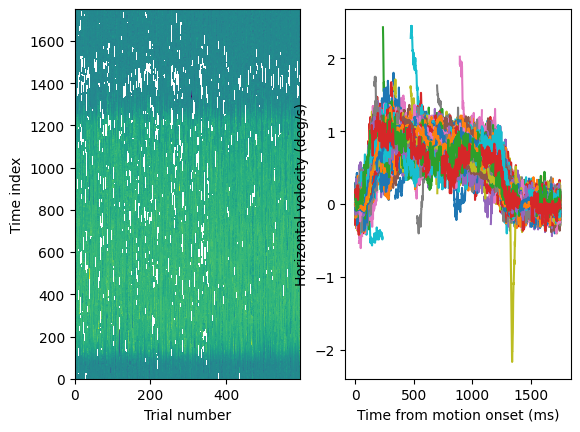

In [7]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].pcolor(purs.hvelocities);
axes[0].set_xlabel('Trial number')
axes[0].set_ylabel('Time index')
axes[1].plot(purs.eye_t,purs.hvelocities);
axes[1].set_xlabel('Time from motion onset (ms)')
axes[1].set_ylabel('Horizontal velocity (deg/s)')

In [8]:
mu, C = purs.computeMeanCov(purs.hvelocities)

print(np.shape(C))
print(np.shape(mu))

(1751, 1751)
(1751,)


Text(0, 0.5, 'Mean horizontal velocity (deg/s)')

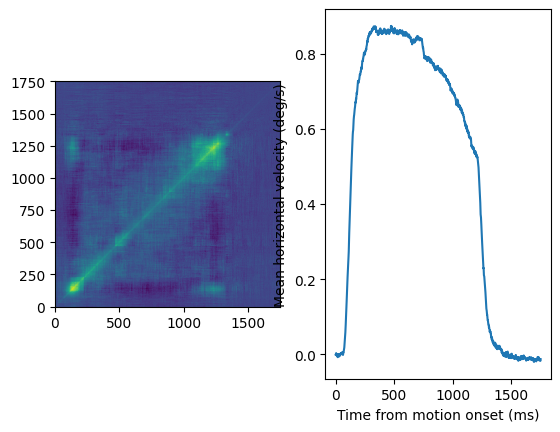

In [9]:

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].pcolor(C);
axes[0].set_aspect('equal', 'box')
axes[1].plot(purs.eye_t,mu)
axes[1].set_xlabel('Time from motion onset (ms)')
axes[1].set_ylabel('Mean horizontal velocity (deg/s)')

In [37]:
x = purs.hvelocities[:,-55]
y = np.logical_not(np.isnan(x))
f = x[y]
print(np.mean(purs.speeds))
print(instrumentNoise)
mu_, C_, C_UnObs, C_ObsObs = purs.conditionalGaussian(mu,np.array(C),f,x_indices=y,obsNoise=instrumentNoise/np.mean(purs.speeds))


11.666666666666666
0.4754257839211303
(1177,)
(574, 1177)


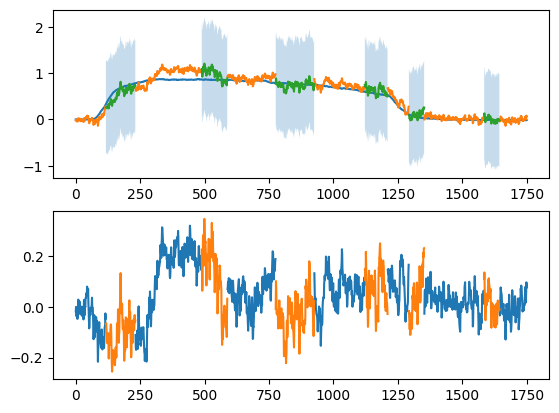

In [38]:
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(purs.eye_t,mu)
axes[0].plot(purs.eye_t,x)
temp = np.empty_like(mu)
temp[y] = np.nan
temp[np.logical_not(y)] = mu_
lb = np.empty_like(mu)
lb[y] = np.nan
lb[np.logical_not(y)] = mu_ - np.diag(C_)
ub = np.empty_like(mu)
ub[y] = np.nan
ub[np.logical_not(y)] = mu_ + np.diag(C_)
axes[0].plot(purs.eye_t,temp)
axes[0].fill_between(purs.eye_t,lb,ub, alpha=0.25)

axes[1].plot(purs.eye_t,x-mu)
axes[1].plot(purs.eye_t,temp-mu)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].pcolor(C_UnObs)
axes[0].set_aspect('equal', 'box')
axes[1].pcolor(C_ObsObs)
axes[1].set_aspect('equal', 'box')
axes[2].pcolor(C_UnObs @ np.linalg.inv(C_ObsObs))
axes[2].set_aspect('equal', 'box')
fig.colorbar(plt.cm.ScalarMappable(), ax=axes[2])

In [154]:
# Test conditionalGaussian
Ntest = 100
Sig = np.ones((Ntest,Ntest))
for i in range(Ntest):
    for j in range(Ntest):
        Sig[i,j] = np.exp( -(i-j)**2/100 )

#Sig = Sig + 0.0005*np.identity(Ntest)

mu_test = np.zeros((Ntest,))
x = np.random.multivariate_normal(mu_test,Sig)
print(x.shape)

t = np.arange(Ntest)
y = np.ones_like(mu_test, dtype=bool)
y[0:10] = False
q = sum(y)
f = x[y]
# muObs = mu_test[y]
# muUn = mu_test[np.logical_not(y)]

# SigUnUn = Sig[0:Ntest-q,0:Ntest-q]
# SigUnObs = Sig[0:Ntest-q,Ntest-q:]
# SigObsObs = Sig[Ntest-q:,Ntest-q:] + 0.0000001*np.identity(q)
# SigObsUn = Sig[Ntest-q:,0:Ntest-q]

# temp = SigUnObs @ np.linalg.inv(SigObsObs)
# mu_ = muUn + temp @ (f-muObs)
mu_, a, b, c = purs.conditionalGaussian(mu_test,Sig,f,x_indices=y,obsNoise=0.0000001)
print(mu_)

(100,)
(90,)
(10, 90)
[-1.01700344 -1.09008182 -1.15429366 -1.21104363 -1.26219179 -1.30925897
 -1.35263253 -1.39101043 -1.42129002 -1.43900478]


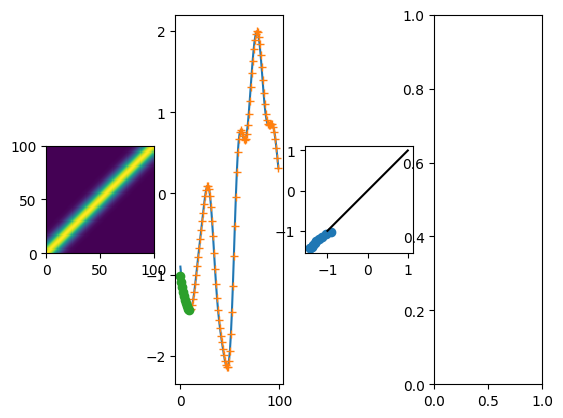

In [155]:
fig, axes = plt.subplots(nrows=1, ncols=4)
axes[0].pcolor(Sig)
axes[0].set_aspect('equal', 'box')
#axes[1].pcolor(SigUnObs)
#axes[1].set_aspect('equal', 'box')
#axes[2].pcolor(SigObsObs)
#xes[2].set_aspect('equal', 'box')
#axes[3].pcolor(temp.T)
axes[1].plot(t,x)
axes[1].plot(t[y],f,'+')
axes[1].plot(t[np.logical_not(y)],mu_,'o')
#axes[2].plot(t[y],f-muObs)
axes[2].plot(x[np.logical_not(y)],mu_,'o')
axes[2].plot([-1,1],[-1,1],'k')
axes[2].set_aspect('equal', 'box')
